In [2]:
import numpy as np
import matplotlib.pyplot as plt
from math import comb
import itertools

## Homogenous Latency

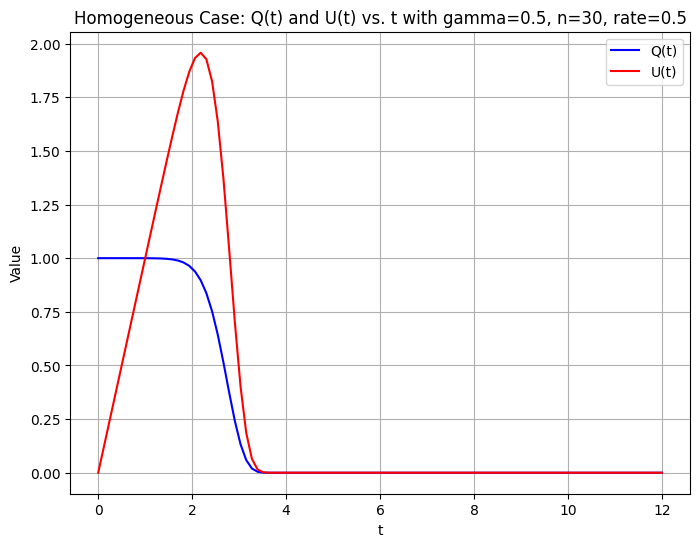

In [18]:
# -- Parameters --
k = 30            # number of attesters
gamma = 0.5       # fraction threshold
mu = 1.0          # marginal reward
t_prev = 0.0      # previous block time
rate = 0.5        # rate of message arrival
T_max = 12.0       # max time to consider
cutoff = 4.0      # cutoff time for attestation
num_points = 100  # number of points in the grid

def p(t):
    """Homogeneous success probability, linearly decreasing in t."""
    if t >= cutoff:
        return 0.0
    else:
        return 1.0 - np.exp(-rate*(cutoff - t))

def Q(t):
    """Binomial-based Q(t): Probability that X >= gamma*k."""
    pt = p(t)
    threshold = int(np.ceil(gamma * k))
    total_prob = 0.0
    for r in range(threshold, k+1):
        # comb(k, r) is the binomial coefficient
        total_prob += comb(k, r) * (pt**r) * ((1-pt)**(k-r))
    return total_prob

# Prepare data
t_values = np.linspace(t_prev, T_max, num_points)
Q_values = [Q(t) for t in t_values]
U_values = [mu*(t - t_prev)*q for t, q in zip(t_values, Q_values)]

# Plot
plt.figure(figsize=(8, 6))
plt.plot(t_values, Q_values, label='Q(t)', color='blue')
plt.plot(t_values, U_values, label='U(t)', color='red')
plt.xlabel('t')
plt.ylabel('Value')
plt.title(f'Homogeneous Case: Q(t) and U(t) vs. t with gamma={gamma}, n={k}, rate={rate}')
plt.legend()
plt.grid(True)
# Save the plot
plt.savefig('homogeneous.png', dpi=300, bbox_inches='tight')
plt.show()


## Heterogenous Latency

### Monte Carlo

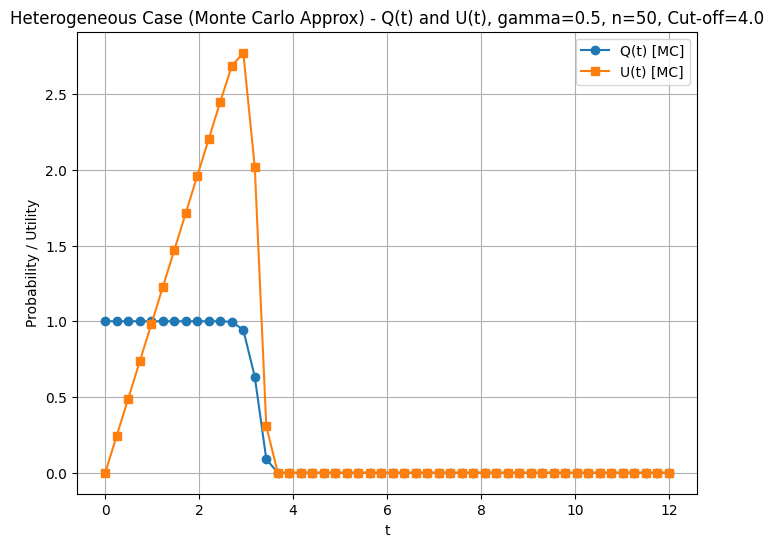

In [ ]:
np.random.seed(42)

# -- Parameters --
k = 50                # number of heterogeneous attesters
gamma = 0.5
mu = 1.0
t_prev = 0.0
T_max = 12.0
cutoff = 4.0      # cutoff time for attestation
n_points = 50
n_monte_carlo = 5000  # number of MC samples to estimate Q(t)

lam = np.random.uniform(1/(T_max/2), 2, k)  

def p_i(t, i):
    """Individual success probability for attester i."""
    if t >= cutoff:
        return 0.0
    else: # The probability of success for attester i Pr[Exp(lam[i]) <= T_max - t]
        return 1.0 - np.exp(-lam[i]*(cutoff - t))#(D[i] - t))

def Q_monte_carlo(t):
    """
    Estimate Q(t) = P(X >= gamma*k) by Monte Carlo:
    1) For each MC trial, draw X_i ~ Bernoulli(p_i(t)).
    2) Check if sum(X_i) >= gamma*k.
    3) Estimate via fraction of trials with sum(X_i) >= gamma*k.
    """
    successes = 0
    threshold = int(np.ceil(gamma * k))
    for _ in range(n_monte_carlo):
        total = 0
        for i_ in range(k):
            # Draw a Bernoulli random variable with probability p_i(t, i_)
            if np.random.rand() < p_i(t, i_): # i.e., when the attester is successful
                total += 1
        if total >= threshold:
            successes += 1
    return successes / n_monte_carlo

# Precompute Q(t) and U(t) over a grid
t_values = np.linspace(t_prev, T_max, n_points)
Q_values = []
U_values = []

for t in t_values:
    Q_t = Q_monte_carlo(t)
    Q_values.append(Q_t)
    U_values.append(mu*(t - t_prev)*Q_t)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(t_values, Q_values, label="Q(t) [MC]", marker='o')
plt.plot(t_values, U_values, label="U(t) [MC]", marker='s')
plt.xlabel("t")
plt.ylabel("Probability / Utility")
plt.title(f"Heterogeneous Case (Monte Carlo Approx) - Q(t) and U(t), gamma={gamma}, n={k}, Cut-off={cutoff}")
plt.legend()
plt.grid(True)
# Save the plot
plt.savefig(f'heterogeneous_mc_{n_monte_carlo}_{k}_{cutoff}.png', dpi=300, bbox_inches='tight')


### Poisson Binomial

Default

Original rates: [1.86858403 0.95167094 1.93886717 1.93330329 1.73051734 0.70648964
 0.87267917 1.7270839  0.74769034 0.47740337 1.18746898 1.88295042
 1.44272129 1.21177881 0.34482357]
Original Setup:
  Max Proposer Utility = 2.8064 at t* = 2.9091

Time taken: 1.6993 seconds.


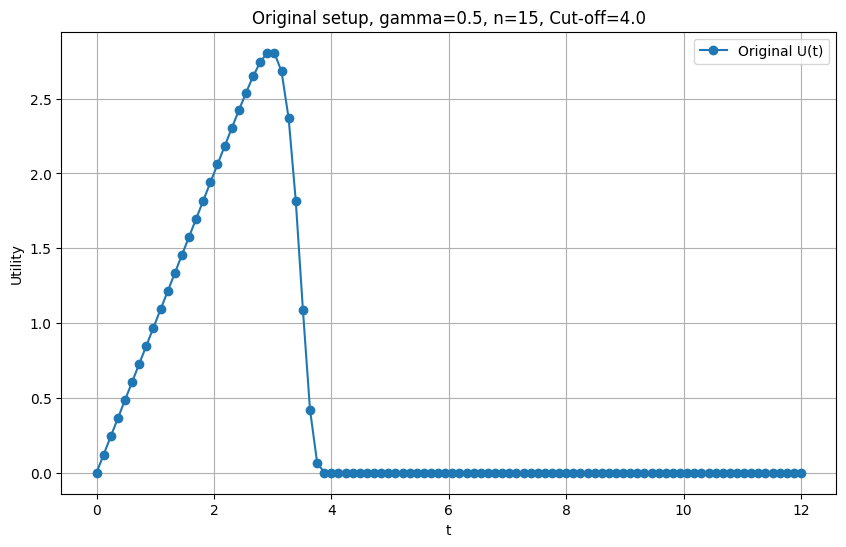

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from math import comb
import itertools
import time

start_time = time.time()

# -- Parameters --
k = 15                # number of heterogeneous attesters
gamma = 0.5
mu = 1.0
t_prev = 0.0
cutoff = 4.0           # Time after which attesters can't attest
T_max = 12.0           # We'll only plot from 0 to this
n_points = 100         # for a slightly finer grid when searching max U

# Random rates (heterogeneous):
lam = np.random.uniform(1/(T_max/2), 2, k)  

def p_i(t, i, lam_array):
    """
    Probability that attester i sees the block if proposed at time t.
    If t >= cutoff: 0. else: 1 - exp(-lam[i]*(cutoff - t)).
    """
    if t >= cutoff:
        return 0.0
    else:
        return 1.0 - np.exp(-lam_array[i]*(cutoff - t))

def Q(t, lam_array):
    """
    Poisson binomial probability that at least gamma*k of these k 
    heterogeneous Bernoulli(p_i(t)) succeed.
    
    For k=5, we do an exact sum over all subsets.
    """
    ps = [p_i(t, i_, lam_array) for i_ in range(k)]
    threshold = int(np.ceil(gamma * k))
    total_prob = 0.0
    
    # Sum over r = threshold..k, then sum over combinations of size r
    for r in range(threshold, k+1):
        for subset in itertools.combinations(range(k), r):
            prob_subset = 1.0
            # multiply p_i(t) for i in the subset
            for idx in subset:
                prob_subset *= ps[idx]
            # multiply (1 - p_i(t)) for i not in the subset
            for idx in set(range(k)) - set(subset):
                prob_subset *= (1.0 - ps[idx])
            total_prob += prob_subset
    return total_prob

def compute_utility_array(lam_array):
    """
    Computes U(t) = mu*(t - t_prev)*Q(t, lam_array) on a grid,
    returns arrays (t_values, U_values, Q_values).
    """
    t_values = np.linspace(t_prev, T_max, n_points)
    Q_values = [Q(t, lam_array) for t in t_values]
    U_values = [mu*(t - t_prev)*q for t, q in zip(t_values, Q_values)]
    return t_values, U_values, Q_values

def find_max_utility(t_values, U_values):
    """
    Given arrays of t_values and U_values, find the max utility and 
    the t that achieves it.
    """
    max_U = max(U_values)
    idx_max = U_values.index(max_U)
    return t_values[idx_max], max_U

# 1) ORIGINAL SETUP
print("Original rates:", lam)

# Compute (t, U) and find max utility in original setup
t_vals_orig, U_vals_orig, Q_vals_orig = compute_utility_array(lam)
t_star_orig, U_star_orig = find_max_utility(t_vals_orig, U_vals_orig)

print(f"Original Setup:")
print(f"  Max Proposer Utility = {U_star_orig:.4f} at t* = {t_star_orig:.4f}")

# 5) (Optional) Plot if desired
plt.figure(figsize=(10, 6))
plt.plot(t_vals_orig, U_vals_orig, label="Original U(t)", marker='o')
plt.xlabel("t")
plt.ylabel("Utility")
plt.title(f"Original setup, gamma={gamma}, n={k}, Cut-off={cutoff}")
plt.grid(True)
plt.legend()

# Save the plot
plt.savefig(f'heterogeneous_poisson_bin_{k}_{cutoff}.png', dpi=300, bbox_inches='tight')

# Print time taken
end_time = time.time()
print(f"\nTime taken: {end_time - start_time:.4f} seconds.")

Changing slowest to fastest

Original rates: [1.29417992 1.98176539 0.42348736 1.1169377  1.77518397 1.52474247
 1.44452886 1.45455415 0.82573378 0.70491838 1.65049545 1.65187456
 1.75629925 1.84094101 1.10412773]
Original Setup:
  Max Proposer Utility = 2.9236 at t* = 3.0303

After changing slowest -> fastest:
  Slowest rate was: 0.4235 => Highest latency was: 2.3613
  Fastest rate was: 1.9818 => Lowest latency was: 0.5046
  Modified rates: [1.29417992 1.98176539 1.98176539 1.1169377  1.77518397 1.52474247
 1.44452886 1.45455415 0.82573378 0.70491838 1.65049545 1.65187456
 1.75629925 1.84094101 1.10412773]
  New Max Proposer Utility = 3.0017 at t* = 3.1515

Difference in Max Proposer Utility: 0.0781
Note: 'Slowest' => smallest lambda => largest mean(Exp).
Utility changed by 0.0781 when slowest lambda was replaced with fastest lambda => delta(lambda)=1.5583.

Time taken: 3.2347 seconds.


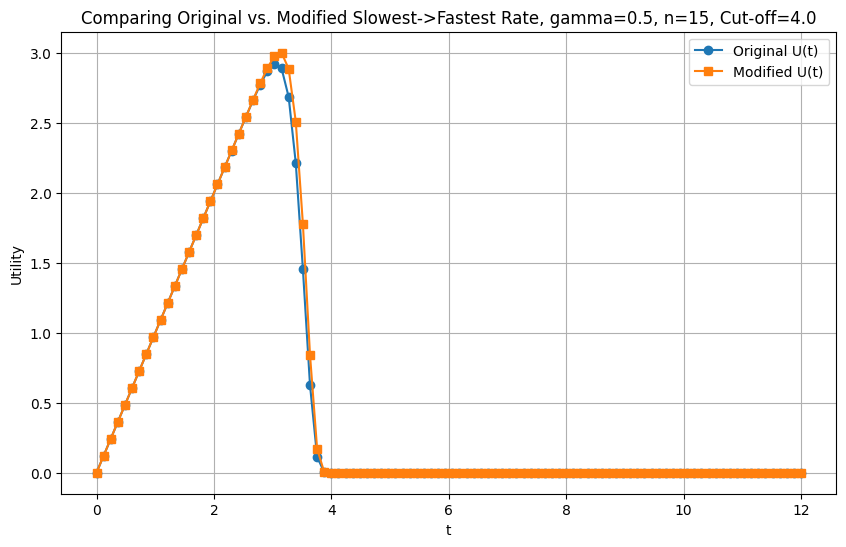

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from math import comb
import itertools
import time

start_time = time.time()

# -- Parameters --
k = 15                # number of heterogeneous attesters
gamma = 0.5
mu = 1.0
t_prev = 0.0
cutoff = 4.0           # Time after which attesters can't attest
T_max = 12.0           # We'll only plot from 0 to this
n_points = 100         # for a slightly finer grid when searching max U

# Random rates (heterogeneous):
lam = np.random.uniform(1/(T_max/2), 2, k)  

def p_i(t, i, lam_array):
    """
    Probability that attester i sees the block if proposed at time t.
    If t >= cutoff: 0. else: 1 - exp(-lam[i]*(cutoff - t)).
    """
    if t >= cutoff:
        return 0.0
    else:
        return 1.0 - np.exp(-lam_array[i]*(cutoff - t))

def Q(t, lam_array):
    """
    Poisson binomial probability that at least gamma*k of these k 
    heterogeneous Bernoulli(p_i(t)) succeed.
    
    For k=5, we do an exact sum over all subsets.
    """
    ps = [p_i(t, i_, lam_array) for i_ in range(k)]
    threshold = int(np.ceil(gamma * k))
    total_prob = 0.0
    
    # Sum over r = threshold..k, then sum over combinations of size r
    for r in range(threshold, k+1):
        for subset in itertools.combinations(range(k), r):
            prob_subset = 1.0
            # multiply p_i(t) for i in the subset
            for idx in subset:
                prob_subset *= ps[idx]
            # multiply (1 - p_i(t)) for i not in the subset
            for idx in set(range(k)) - set(subset):
                prob_subset *= (1.0 - ps[idx])
            total_prob += prob_subset
    return total_prob

def compute_utility_array(lam_array):
    """
    Computes U(t) = mu*(t - t_prev)*Q(t, lam_array) on a grid,
    returns arrays (t_values, U_values, Q_values).
    """
    t_values = np.linspace(t_prev, T_max, n_points)
    Q_values = [Q(t, lam_array) for t in t_values]
    U_values = [mu*(t - t_prev)*q for t, q in zip(t_values, Q_values)]
    return t_values, U_values, Q_values

def find_max_utility(t_values, U_values):
    """
    Given arrays of t_values and U_values, find the max utility and 
    the t that achieves it.
    """
    max_U = max(U_values)
    idx_max = U_values.index(max_U)
    return t_values[idx_max], max_U

# 1) ORIGINAL SETUP
print("Original rates:", lam)

# Compute (t, U) and find max utility in original setup
t_vals_orig, U_vals_orig, Q_vals_orig = compute_utility_array(lam)
t_star_orig, U_star_orig = find_max_utility(t_vals_orig, U_vals_orig)

print(f"Original Setup:")
print(f"  Max Proposer Utility = {U_star_orig:.4f} at t* = {t_star_orig:.4f}")

# 2) Modify the slowest latency to the fastest one
lam_modified = lam.copy()
min_idx = np.argmin(lam_modified)  # index of slowest (lowest lambda)
max_idx = np.argmax(lam_modified)  # index of fastest (highest lambda)
slowest_rate = lam_modified[min_idx]
fastest_rate = lam_modified[max_idx]

# Overwrite the slowest rate with the fastest
lam_modified[min_idx] = fastest_rate

print("\nAfter changing slowest -> fastest:")
print(f"  Slowest rate was: {slowest_rate:.4f} => Highest latency was: {(1/slowest_rate):.4f}")
print(f"  Fastest rate was: {fastest_rate:.4f} => Lowest latency was: {(1/fastest_rate):.4f}")
print("  Modified rates:", lam_modified)

# Recompute max utility with this modification
t_vals_mod, U_vals_mod, Q_vals_mod = compute_utility_array(lam_modified)
t_star_mod, U_star_mod = find_max_utility(t_vals_mod, U_vals_mod)

print(f"  New Max Proposer Utility = {U_star_mod:.4f} at t* = {t_star_mod:.4f}")

# 3) Print the difference in max utility
delta_utility = U_star_mod - U_star_orig
print(f"\nDifference in Max Proposer Utility: {delta_utility:.4f}")

# 4) Relate it to difference in latency
delta_rate = fastest_rate - slowest_rate
delta_latency = (1/slowest_rate) - (1/fastest_rate)
print("Note: 'Slowest' => smallest lambda => largest mean(Exp).")
print(f"Utility changed by {delta_utility:.4f} when slowest lambda"
      f" was replaced with fastest lambda => delta(lambda)={delta_rate:.4f}.")

# 5) (Optional) Plot if desired
plt.figure(figsize=(10, 6))
plt.plot(t_vals_orig, U_vals_orig, label="Original U(t)", marker='o')
plt.plot(t_vals_mod, U_vals_mod, label="Modified U(t)", marker='s')
plt.xlabel("t")
plt.ylabel("Utility")
plt.title(f"Comparing Original vs. Modified Slowest->Fastest Rate, gamma={gamma}, n={k}, Cut-off={cutoff}")
plt.grid(True)
plt.legend()

# Save the plot
plt.savefig(f'heterogeneous_poisson_bin_comparison_{k}_{cutoff}.png', dpi=300, bbox_inches='tight')

# Print time taken
end_time = time.time()
print(f"\nTime taken: {end_time - start_time:.4f} seconds.")

Potential Function setup

In [4]:
# -------------------
# (1) Setup as before
# -------------------
k = 5                 
gamma = 0.5
mu = 1.0
t_prev = 0.0
cutoff = 4.0         
T_max = 12.0          
n_points = 100        

# We'll define a "compute_max_utility(lam_array)" helper
import matplotlib.pyplot as plt

def p_i(t, i, lam_array):
    """Attester i success probability, if proposer chooses t."""
    if t >= cutoff:
        return 0.0
    else:
        return 1.0 - np.exp(-lam_array[i]*(cutoff - t))

def Q(t, lam_array):
    """Poisson binomial for X >= gamma*k with heterogeneous p_i(t)."""
    ps = [p_i(t, i_, lam_array) for i_ in range(k)]
    threshold = int(np.ceil(gamma * k))
    total_prob = 0.0
    for r in range(threshold, k+1):
        for subset in itertools.combinations(range(k), r):
            prob_subset = 1.0
            for idx in subset:
                prob_subset *= ps[idx]
            for idx in set(range(k)) - set(subset):
                prob_subset *= (1.0 - ps[idx])
            total_prob += prob_subset
    return total_prob

def compute_max_utility(lam_array):
    """
    Return the maximum utility (VoL) = max_{t} mu*(t - t_prev)*Q(t, lam_array)
    over a discrete grid of t in [t_prev, T_max].
    """
    t_values = np.linspace(t_prev, T_max, n_points)
    best_utility = 0.0
    for t in t_values:
        val = mu*(t - t_prev)*Q(t, lam_array)
        if val > best_utility:
            best_utility = val
    return best_utility

# -----------------------
# (2) Potential function
# -----------------------
def phi(lam_array):
    """Potential function = sum of rates (toy example)."""
    return sum(lam_array)

# -----------------------
# (3) Original array
# -----------------------
# Generate random rates
np.random.seed(42)
lam_orig = np.random.uniform(1/(T_max/2), 2, k)

# Compute original potential and max utility
phi_orig = phi(lam_orig)
Umax_orig = compute_max_utility(lam_orig)

print("Original lam:", lam_orig)
print(f"phi_orig = {phi_orig:.4f},  Umax_orig = {Umax_orig:.4f}")

# ------------------------------------------------
# (4) Modify one player's rate (unilateral change)
# ------------------------------------------------
# Example: pick the slowest rate index, replace it with the fastest rate
min_idx = np.argmin(lam_orig)
max_idx = np.argmax(lam_orig)
lam_modified = lam_orig.copy()
lam_modified[min_idx] = lam_orig[max_idx]  # slowest -> fastest

# Compute new potential and new max utility
phi_modified = phi(lam_modified)
Umax_modified = compute_max_utility(lam_modified)

print("\nAfter unilateral change (slowest -> fastest):")
print("Modified lam:", lam_modified)
print(f"phi_modified = {phi_modified:.4f},  Umax_modified = {Umax_modified:.4f}")

# Differences
delta_phi = phi_modified - phi_orig
delta_Umax = Umax_modified - Umax_orig

print(f"\nDelta phi = {delta_phi:.4f}")
print(f"Delta Umax = {delta_Umax:.4f}")

# Check if they match
if abs(delta_phi - delta_Umax) < 1e-2:
    print("They match => this is consistent with a potential game (for this move).")
else:
    print("They do NOT match => not a potential game, or at least not with this phi.")


Original lam: [0.85332355 1.9096429  1.50865556 1.26420722 0.45270084]
phi_orig = 5.9885,  Umax_orig = 2.4575

After unilateral change (slowest -> fastest):
Modified lam: [0.85332355 1.9096429  1.50865556 1.26420722 1.9096429 ]
phi_modified = 7.4455,  Umax_modified = 2.7236

Delta phi = 1.4569
Delta Umax = 0.2660
They do NOT match => not a potential game, or at least not with this phi.


## Infinite Attesters

In [ ]:
# 1) Parameters
mu = 1.0
gamma = 0.5
t_prev = 0.0

# We'll define a simple piecewise linear m(t):
#    m(t) = 1 - alpha*(t - t_prev), for t in [t_prev, t_prev + 1/alpha]
#    m(t) = 0 for t >= t_prev + 1/alpha
alpha = 0.2  # slope factor, so that m(t) hits zero at t = t_prev + (1/alpha)
T_max = 12.0  # max time to plot
n_points = 300

def m_t(t):
    """
    Example decreasing function for the 'average success probability'.
    For t >= t_prev + 1/alpha, it is zero.
    """
    val = 1.0 - alpha*(t - t_prev)
    return max(0.0, val)

def Q_infinite(t):
    """
    Step function: 1 if m(t) >= gamma, else 0.
    """
    return 1.0 if m_t(t) >= gamma else 0.0

def U_infinite(t):
    """
    Utility in large-k limit: U(t) = mu*(t - t_prev)*Q_infinite(t).
    """
    return mu*(t - t_prev)*Q_infinite(t)

# 2) Build arrays for plotting
t_vals = np.linspace(t_prev, T_max, n_points)
m_vals = [m_t(t) for t in t_vals]
Q_vals = [Q_infinite(t) for t in t_vals]
U_vals = [U_infinite(t) for t in t_vals]

# 3) Plot
plt.figure(figsize=(10,6))

# Plot m(t)
plt.plot(t_vals, m_vals, label='m(t) (avg. success prob)', color='blue')

# Plot Q_infinite(t)
plt.plot(t_vals, Q_vals, label='Q(t) = 1{ m(t) >= gamma }', color='red')

# Plot U_infinite(t)
plt.plot(t_vals, U_vals, label='U(t)', color='green')

# Draw a horizontal line at gamma for reference
plt.axhline(y=gamma, color='gray', linestyle='--', label='gamma')

plt.xlabel('t')
plt.ylabel('Value')
plt.title(f'Large-k Approx: Step Function Q(t) and Resulting Utility U(t) vs. t, gamma={gamma}')
plt.grid(True)
plt.legend()
# Save the plot
plt.savefig('large_k_approx.png', dpi=300, bbox_inches='tight')
plt.show()
